In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2, MockDevice
from pulser.waveforms import InterpolatedWaveform, RampWaveform


from src.spectral_clustering import add_correlation_to_graph, data_to_coordinates, get_corr11_cost, get_allowed_graph, draw_graph
from src.utils import bitnumber_to_bittuple, bitnumber_to_state, get_bitnumber_energy, get_2d_topology
from src.softmax import observations_to_dataset
from src.opt import calculate_full_gradient

### Define the problem Hamiltonian

In [2]:
nx = 4
ny = 3
n_qubits = nx*ny

topo = get_2d_topology(nx, ny)

next_nearest = [
    (ii, n_qubits-nx+ii) for ii in range(nx)
]

In [3]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d 
#
Jzzs=4.0 # zz interaction
hz=1.0 
#
basis = spin_basis_1d(n_qubits, pauli=False)


J_zz = [[Jzzs,i, j] for i, j in topo] 
J_zz.extend([[Jzzs * 2, i, j] for i, j in next_nearest])

h_list = [hz] * n_qubits  
h_z = [[i / n_qubits * 2, i] for i, h in enumerate(h_list)]
static = [["zz",J_zz],["z",h_z]]
dynamic=[]
H = hamiltonian(static,dynamic,basis=basis,dtype=np.float64, check_symm=False)
#
##### various exact diagonalisation routines #####
E, V = H.eigh()


Hermiticity check passed!


### Get First Observations

In [4]:
np.random.seed(1234)
rand_bitnumers = np.random.choice(np.arange(2**n_qubits), size=20, replace=False)
data_list = [bitnumber_to_bittuple(ii, n_qubits) for ii in rand_bitnumers]

In [5]:
energies = [get_bitnumber_energy(num, H, n_qubits) for num in rand_bitnumers]

print(np.round(energies, 2))

[-7.    6.   -0.    0.33  2.33  4.67 -4.33 -3.83 -7.83  2.17  2.33 -9.17
 -4.   -7.83 -1.83 -1.33  2.83 -5.67 -4.67 -5.  ]


In [6]:
data_dict = observations_to_dataset(data_list, energies, T=1)
print("Training Data")
data_dict

T = 1
Training Data


{(0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1): 0.06666896503402663,
 (1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0): 1.5069382219940204e-07,
 (0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0): 6.079422687671352e-05,
 (1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1): 4.3560967059291874e-05,
 (1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0): 5.895335815030021e-06,
 (1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1): 5.716823152049671e-07,
 (0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1): 0.004632389780016449,
 (1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0): 0.0028096864293194403,
 (1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1): 0.1534036812140721,
 (0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0): 6.964516352425491e-06,
 (0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0): 5.89533581503001e-06,
 (0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0): 0.5819626203480387,
 (0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0): 0.0033192523201638147,
 (1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1): 0.1534036812140721,
 (1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0): 0.0003802497087180134,
 (1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1): 0.00023063310668427337,
 (1, 1, 1, 1, 1, 1

### Measure Correlations

In [7]:
## define the basis graph
base_graph = get_allowed_graph("all", n_qubits)
## calculate the correlations
data_graph = add_correlation_to_graph(base_graph, data_dict)

all topology


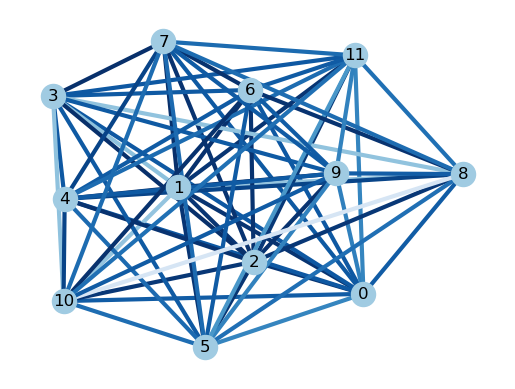

In [8]:
draw_graph(data_graph)
plt.savefig("figures/correlation_graph.png")

### Get Unscaled Coordinates via Spectral Graph Theory

In [9]:
coords1, coords2 = data_to_coordinates(data_dict)

all topology


In [10]:
coords = np.array([[c1, c2] for c1, c2 in  zip(coords1, coords2)])

In [11]:
dists = np.array([[np.linalg.norm(this - that) for that in coords] for this in coords]).flatten()
min_dist = min(dists[dists > 1e-1])
scaled_coords = coords * 4.01/min_dist

### Scale Coordinates with Custom Optimization

In [12]:
def cost_function(coords, target_distribution):
    n_qubits = len(coords)
    
    cost = 0
    for i in range(n_qubits):
        for j in range(i):
            x1 = coords[i]
            x2 = coords[j]
            corr1_cost = get_corr11_cost(target_distribution, i, j)
            dist = np.linalg.norm(x1-x2)
            cost += dist**2 * corr1_cost
            if dist < 4.1:
                cost += (4.1-dist)**2 * 10
            
    return cost

In [13]:
lr = 0.002
costs = []
opt_coords = scaled_coords
costs.append(cost_function(opt_coords, target_distribution=data_dict))
for _ in tqdm(range(200)):
    flat_coords = opt_coords.flatten()
    grad = calculate_full_gradient(flat_coords, lambda x: cost_function(np.reshape(x, (n_qubits, 2)), data_dict)).reshape(n_qubits, 2)
    opt_coords = opt_coords - lr * grad
    costs.append(cost_function(opt_coords, target_distribution=data_dict))



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 101.23it/s]


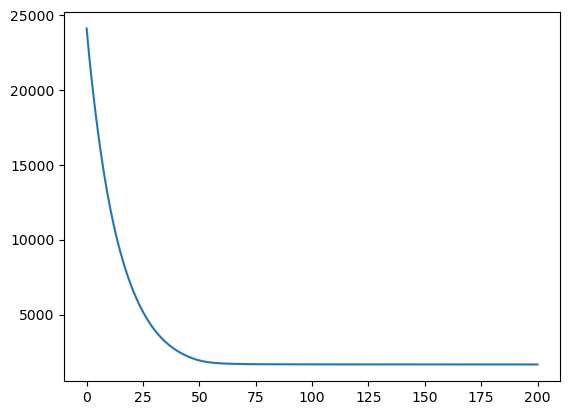

In [14]:
plt.plot(costs)

In [15]:
dists = np.array([[np.linalg.norm(this - that) for that in opt_coords] for this in opt_coords]).flatten()
min_dist = min(dists[dists > 1e-5])
scaled_opt_coords = opt_coords * 7.5/min_dist

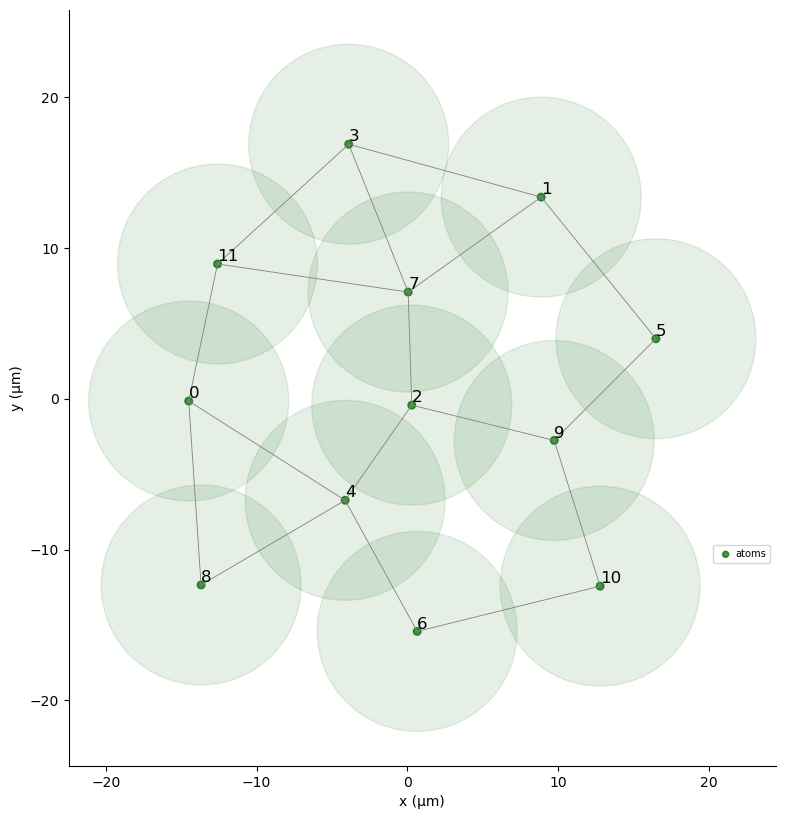

In [16]:
qubits = dict(enumerate(scaled_opt_coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
    fig_name="figures/final_positions.png"
)

### Apply Adiabatic Protocol

In [17]:
# Setup

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000


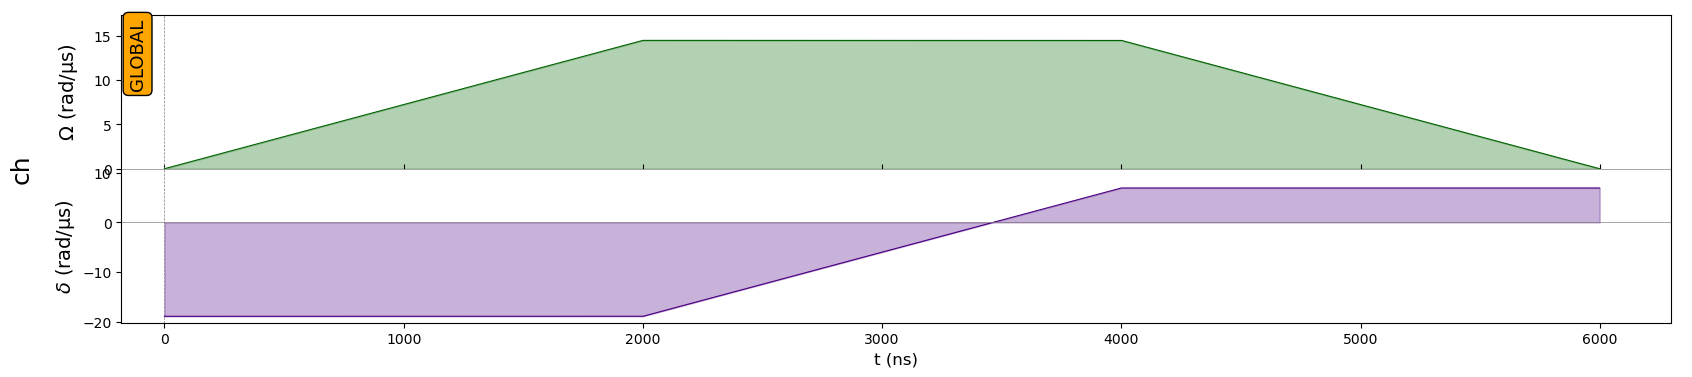

In [18]:
delta_f = 1.1 * U
seq = Sequence(reg, MockDevice)
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)
seq.declare_channel("ch", "rydberg_global")
seq.add(rise, "ch")
seq.add(sweep, "ch")
seq.add(fall, "ch")
seq.draw()

In [19]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(progress_bar=True)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.30s. Est. time left: 00:00:00:01
30.0%. Run time:   0.47s. Est. time left: 00:00:00:01
40.0%. Run time:   0.71s. Est. time left: 00:00:00:01
50.0%. Run time:   0.95s. Est. time left: 00:00:00:00
60.0%. Run time:   1.23s. Est. time left: 00:00:00:00
70.0%. Run time:   1.52s. Est. time left: 00:00:00:00
80.0%. Run time:   1.82s. Est. time left: 00:00:00:00
90.0%. Run time:   2.13s. Est. time left: 00:00:00:00
Total run time:   2.39s


### Sample Final State And Compare

In [20]:
sample_dict = results.sample_final_state(N_samples = 10_000)

empirical_energies = [get_bitnumber_energy(int(bt, base=2), H, n_qubits) for bt in sample_dict.keys()]

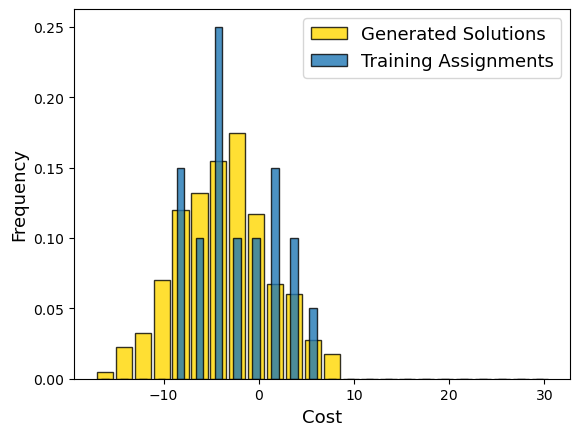

In [21]:
bins = np.linspace(np.min(E), np.max(E), 25)

cnts, ens = np.histogram(empirical_energies, bins=bins)
ens = np.array([(ens[ii] + ens[ii+1])/2 for ii in range(len(ens)-1)])
plt.bar(ens, cnts/sum(cnts), alpha=0.8, color="gold", linewidth=1, edgecolor="k", label="Generated Solutions", width=1.7)

cnts, ens = np.histogram(energies, bins=bins)
ens = np.array([(ens[ii] + ens[ii+1])/2 for ii in range(len(ens)-1)])
plt.bar(ens, cnts/sum(cnts), alpha=0.8, edgecolor="k", label="Training Assignments")

plt.xlabel("Cost", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend(fontsize=13)
plt.savefig("figures/comparison_training_data.png")
plt.show()

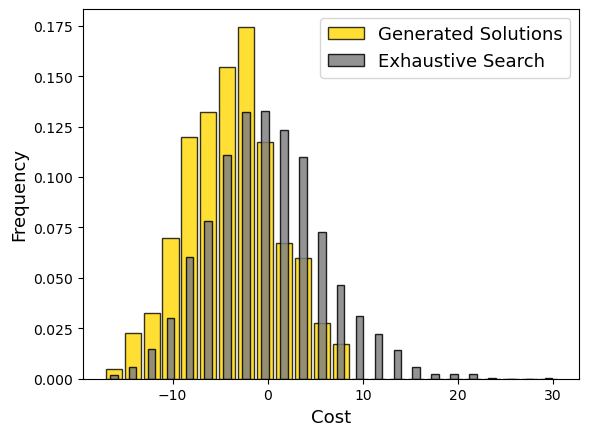

In [22]:
bins = np.linspace(np.min(E), np.max(E), 25)

cnts, ens = np.histogram(empirical_energies, bins=bins)
ens = np.array([(ens[ii] + ens[ii+1])/2 for ii in range(len(ens)-1)])
plt.bar(ens, cnts/sum(cnts), alpha=0.8, color="gold", linewidth=1, edgecolor="k", label="Generated Solutions", width=1.7)

cnts, ens = np.histogram(E, bins=bins)
ens = np.array([(ens[ii] + ens[ii+1])/2 for ii in range(len(ens)-1)])
plt.bar(ens, cnts/sum(cnts), alpha=0.85, color="grey", edgecolor="k", label="Exhaustive Search")
plt.xlabel("Cost", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend(fontsize=13)
plt.savefig("figures/comparison_exhaustive.png")
plt.show()

In [23]:
min(empirical_energies), min(energies), min(E)

(-17.166666666666664, -9.166666666666668, -17.16666666666667)